In [1]:
import sys
sys.path.insert(0, '/home/cscadmin/CyberResearch/CAT-Transformer/model/')
from updatedModel import CATTransformer, Combined_Dataset, train, test
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState

/home/cscadmin/miniconda3/envs/torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [3]:
# df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\train.csv')
# df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\test.csv')
# df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/train.csv')
# df_test = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/test.csv')
# df_val = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/validation.csv')


df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/train.csv')
df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/test.csv')
df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/validation.csv')


# df_train.columns
cont_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
target = ['class']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put one of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print("target classes",target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns=[], num_columns=cont_columns, task1_column='class')
val_dataset = Combined_Dataset(df_val, cat_columns=[], num_columns=cont_columns, task1_column='class')
test_dataset = Combined_Dataset(df_test, cat_columns=[], num_columns=cont_columns, task1_column='class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

target classes [100]


# RUN EXPERIMENTS

1. Using Optuna to optimize CAT-Transformers hyperparameters for your dataset

In [4]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over

    alpha = trial.suggest_float('alpha', 0.1, 5, step=0.1)
    embed_size = trial.suggest_int('embed_size', 100, 320, step=20)
    num_layers = trial.suggest_int('num_layers', 1,2)
    heads = trial.suggest_categorical('heads', [1,2,5,10,20])
    forward_expansion = trial.suggest_int('forward_expansion', 2,8)
    decoder_dropout = trial.suggest_float('decoder_dropout', 0, .5, step=.1)
    classification_dropout = trial.suggest_float('classificiation_dropout', 0, 0.5, step=0.1)
    pre_norm_on = trial.suggest_categorical('pre_norm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 2, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1, log=True)

    num_epochs = 250


    # Create your model with the sampled hyperparameters
    model = CATTransformer(alpha=alpha,
                           embed_size=embed_size,
                           n_cont=len(cont_columns),
                           cat_feat=[],
                           num_layers=num_layers,
                           heads=heads,
                           forward_expansion=forward_expansion,
                           decoder_dropout=decoder_dropout,
                           classification_dropout=classification_dropout,
                           pre_norm_on=pre_norm_on,
                           mlp_scale_classification=mlp_scale_classification,
                           regression_on=False,
                           targets_classes=target_classes).to(device_in_use)

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
        val_loss, val_acc = test(regression_on=False,
                               dataloader=val_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
        
        # Check if we should early stop based on validation accuracy
        if early_stopping(val_acc):
            break
    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation Accuracy = {val_acc:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return val_acc

In [5]:
# Set the number of optimization trials
num_trials = 100

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy (at Early Stopping):", best_val_accuracy)

[I 2023-12-04 10:10:24,533] A new study created in memory with name: no-name-c5edabf6-c31e-44d7-b699-aa766de7900b
Best trial: 0. Best value: 0.245015:   1%|          | 1/100 [20:20<33:33:07, 1220.07s/it]

[I 2023-12-04 10:30:44,606] Trial 0 finished with value: 0.24501482769199304 and parameters: {'alpha': 4.3, 'embed_size': 280, 'num_layers': 2, 'heads': 5, 'forward_expansion': 6, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.0, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.015204763373779191}. Best is trial 0 with value: 0.24501482769199304.


Best trial: 1. Best value: 0.350752:   2%|▏         | 2/100 [40:51<33:23:52, 1226.86s/it]

[I 2023-12-04 10:51:16,224] Trial 1 finished with value: 0.3507516105941303 and parameters: {'alpha': 1.8000000000000003, 'embed_size': 320, 'num_layers': 2, 'heads': 5, 'forward_expansion': 7, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.2, 'pre_norm_on': False, 'mlp_scale_classification': 8, 'learning_rate': 0.0002946266171398245}. Best is trial 1 with value: 0.3507516105941303.


Best trial: 2. Best value: 0.366193:   3%|▎         | 3/100 [1:01:16<33:01:58, 1225.96s/it]

[I 2023-12-04 11:11:41,110] Trial 2 finished with value: 0.3661928622558544 and parameters: {'alpha': 0.2, 'embed_size': 280, 'num_layers': 2, 'heads': 10, 'forward_expansion': 5, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.2, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00015605980210065074}. Best is trial 2 with value: 0.3661928622558544.


Best trial: 2. Best value: 0.366193:   4%|▍         | 4/100 [1:21:05<32:17:57, 1211.23s/it]

[I 2023-12-04 11:31:29,755] Trial 3 finished with value: 0.3495244912567747 and parameters: {'alpha': 5.0, 'embed_size': 140, 'num_layers': 2, 'heads': 5, 'forward_expansion': 4, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00444888696834504}. Best is trial 2 with value: 0.3661928622558544.


Best trial: 2. Best value: 0.366193:   5%|▌         | 5/100 [1:39:25<30:54:12, 1171.08s/it]

[I 2023-12-04 11:49:49,653] Trial 4 finished with value: 0.05869720830350752 and parameters: {'alpha': 3.9000000000000004, 'embed_size': 120, 'num_layers': 1, 'heads': 2, 'forward_expansion': 8, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': False, 'mlp_scale_classification': 6, 'learning_rate': 0.017851430430389743}. Best is trial 2 with value: 0.3661928622558544.


Best trial: 2. Best value: 0.366193:   6%|▌         | 6/100 [1:59:19<30:46:54, 1178.87s/it]

[I 2023-12-04 12:09:43,655] Trial 5 finished with value: 0.13917578484507617 and parameters: {'alpha': 2.6, 'embed_size': 160, 'num_layers': 2, 'heads': 1, 'forward_expansion': 5, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.005343496662534427}. Best is trial 2 with value: 0.3661928622558544.


Best trial: 2. Best value: 0.366193:   7%|▋         | 7/100 [2:18:57<30:27:07, 1178.79s/it]

[I 2023-12-04 12:29:22,258] Trial 6 finished with value: 0.318232948154208 and parameters: {'alpha': 0.8, 'embed_size': 120, 'num_layers': 2, 'heads': 1, 'forward_expansion': 7, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.0, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00019771433294379882}. Best is trial 2 with value: 0.3661928622558544.


Best trial: 7. Best value: 0.37918:   8%|▊         | 8/100 [2:38:48<30:13:26, 1182.67s/it] 

[I 2023-12-04 12:49:13,258] Trial 7 finished with value: 0.3791798752428674 and parameters: {'alpha': 2.7, 'embed_size': 180, 'num_layers': 2, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00015978048613425142}. Best is trial 7 with value: 0.3791798752428674.


Best trial: 7. Best value: 0.37918:   9%|▉         | 9/100 [2:58:03<29:40:32, 1173.99s/it]

[I 2023-12-04 13:08:28,146] Trial 8 finished with value: 0.3213007464975969 and parameters: {'alpha': 4.3999999999999995, 'embed_size': 300, 'num_layers': 2, 'heads': 1, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.1, 'pre_norm_on': False, 'mlp_scale_classification': 7, 'learning_rate': 0.00012408632300668567}. Best is trial 7 with value: 0.3791798752428674.


Best trial: 7. Best value: 0.37918:  10%|█         | 10/100 [3:16:37<28:53:13, 1155.48s/it]

[I 2023-12-04 13:27:02,195] Trial 9 finished with value: 0.05869720830350752 and parameters: {'alpha': 0.9, 'embed_size': 300, 'num_layers': 1, 'heads': 2, 'forward_expansion': 7, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': False, 'mlp_scale_classification': 3, 'learning_rate': 0.026054799615437548}. Best is trial 7 with value: 0.3791798752428674.


Best trial: 7. Best value: 0.37918:  11%|█         | 11/100 [3:35:41<28:28:53, 1152.06s/it]

[I 2023-12-04 13:46:06,505] Trial 10 finished with value: 0.3728397586665303 and parameters: {'alpha': 2.6, 'embed_size': 200, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.0009932006688458401}. Best is trial 7 with value: 0.3791798752428674.


Best trial: 7. Best value: 0.37918:  12%|█▏        | 12/100 [3:54:38<28:02:57, 1147.47s/it]

[I 2023-12-04 14:05:03,471] Trial 11 finished with value: 0.37181715921873404 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 200, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.0007641031384598028}. Best is trial 7 with value: 0.3791798752428674.


Best trial: 12. Best value: 0.379691:  13%|█▎        | 13/100 [4:13:50<27:45:49, 1148.84s/it]

[I 2023-12-04 14:24:15,462] Trial 12 finished with value: 0.3796911749667655 and parameters: {'alpha': 3.1, 'embed_size': 220, 'num_layers': 1, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.0008983313752625082}. Best is trial 12 with value: 0.3796911749667655.


Best trial: 12. Best value: 0.379691:  14%|█▍        | 14/100 [4:32:50<27:22:27, 1145.90s/it]

[I 2023-12-04 14:43:14,574] Trial 13 finished with value: 0.3781572757950711 and parameters: {'alpha': 3.4000000000000004, 'embed_size': 240, 'num_layers': 1, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.0007604782203135962}. Best is trial 12 with value: 0.3796911749667655.


Best trial: 12. Best value: 0.379691:  15%|█▌        | 15/100 [4:51:51<27:01:39, 1144.70s/it]

[I 2023-12-04 15:02:16,486] Trial 14 finished with value: 0.379282135187647 and parameters: {'alpha': 1.8000000000000003, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.0004531594450622651}. Best is trial 12 with value: 0.3796911749667655.


Best trial: 12. Best value: 0.379691:  16%|█▌        | 16/100 [5:10:53<26:41:09, 1143.68s/it]

[I 2023-12-04 15:21:17,807] Trial 15 finished with value: 0.3733510583904285 and parameters: {'alpha': 1.9000000000000001, 'embed_size': 240, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.0018258964561165103}. Best is trial 12 with value: 0.3796911749667655.


Best trial: 16. Best value: 0.381634:  17%|█▋        | 17/100 [5:29:47<26:18:15, 1140.91s/it]

[I 2023-12-04 15:40:12,285] Trial 16 finished with value: 0.3816341139175785 and parameters: {'alpha': 1.8000000000000003, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.0004045699484853333}. Best is trial 16 with value: 0.3816341139175785.


Best trial: 16. Best value: 0.381634:  18%|█▊        | 18/100 [5:48:56<26:02:25, 1143.24s/it]

[I 2023-12-04 15:59:20,931] Trial 17 finished with value: 0.05869720830350752 and parameters: {'alpha': 3.4000000000000004, 'embed_size': 220, 'num_layers': 1, 'heads': 20, 'forward_expansion': 4, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.06331543535346168}. Best is trial 16 with value: 0.3816341139175785.


Best trial: 16. Best value: 0.381634:  19%|█▉        | 19/100 [6:07:38<25:34:39, 1136.78s/it]

[I 2023-12-04 16:18:02,672] Trial 18 finished with value: 0.19194191635136518 and parameters: {'alpha': 1.4000000000000001, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 2, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': False, 'mlp_scale_classification': 5, 'learning_rate': 0.0017140357909068429}. Best is trial 16 with value: 0.3816341139175785.


Best trial: 16. Best value: 0.381634:  20%|██        | 20/100 [6:26:40<25:17:53, 1138.42s/it]

[I 2023-12-04 16:37:04,911] Trial 19 finished with value: 0.3703855199918192 and parameters: {'alpha': 2.1, 'embed_size': 180, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.0003313405075708988}. Best is trial 16 with value: 0.3816341139175785.


Best trial: 16. Best value: 0.381634:  21%|██        | 21/100 [6:45:59<25:07:12, 1144.71s/it]

[I 2023-12-04 16:56:24,283] Trial 20 finished with value: 0.3671132017588711 and parameters: {'alpha': 3.3000000000000003, 'embed_size': 220, 'num_layers': 1, 'heads': 10, 'forward_expansion': 4, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.2, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.0004109458498502152}. Best is trial 16 with value: 0.3816341139175785.


Best trial: 16. Best value: 0.381634:  22%|██▏       | 22/100 [7:05:35<25:00:08, 1153.96s/it]

[I 2023-12-04 17:15:59,820] Trial 21 finished with value: 0.3776459760711729 and parameters: {'alpha': 1.4000000000000001, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.0005755991527211236}. Best is trial 16 with value: 0.3816341139175785.


Best trial: 22. Best value: 0.382452:  23%|██▎       | 23/100 [7:25:32<24:57:33, 1166.93s/it]

[I 2023-12-04 17:35:57,000] Trial 22 finished with value: 0.38245219347581555 and parameters: {'alpha': 2.2, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00010001556625194633}. Best is trial 22 with value: 0.38245219347581555.


Best trial: 22. Best value: 0.382452:  24%|██▍       | 24/100 [7:45:19<24:45:46, 1172.98s/it]

[I 2023-12-04 17:55:44,089] Trial 23 finished with value: 0.3686471009305655 and parameters: {'alpha': 2.3000000000000003, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00021696446223941156}. Best is trial 22 with value: 0.38245219347581555.


Best trial: 24. Best value: 0.384088:  25%|██▌       | 25/100 [8:05:00<24:29:02, 1175.24s/it]

[I 2023-12-04 18:15:24,592] Trial 24 finished with value: 0.3840883525922896 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00010001711214772144}. Best is trial 24 with value: 0.3840883525922896.


Best trial: 25. Best value: 0.386645:  26%|██▌       | 26/100 [8:25:04<24:20:17, 1184.02s/it]

[I 2023-12-04 18:35:29,107] Trial 25 finished with value: 0.3866448512117803 and parameters: {'alpha': 1.2000000000000002, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00010203591360207313}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  27%|██▋       | 27/100 [8:44:04<23:44:27, 1170.78s/it]

[I 2023-12-04 18:54:28,999] Trial 26 finished with value: 0.38050925452500256 and parameters: {'alpha': 1.2000000000000002, 'embed_size': 320, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': False, 'mlp_scale_classification': 6, 'learning_rate': 0.0001008771407558167}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  28%|██▊       | 28/100 [9:03:52<23:31:01, 1175.85s/it]

[I 2023-12-04 19:14:16,674] Trial 27 finished with value: 0.3789753553533081 and parameters: {'alpha': 0.1, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00011800962877905319}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  29%|██▉       | 29/100 [9:23:48<23:18:34, 1181.90s/it]

[I 2023-12-04 19:34:12,692] Trial 28 finished with value: 0.360773085182534 and parameters: {'alpha': 0.7000000000000001, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00024836408092917053}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  30%|███       | 30/100 [9:43:37<23:01:38, 1184.26s/it]

[I 2023-12-04 19:54:02,474] Trial 29 finished with value: 0.3815318539727989 and parameters: {'alpha': 3.8000000000000003, 'embed_size': 300, 'num_layers': 1, 'heads': 5, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00010822730613904577}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  31%|███       | 31/100 [10:03:21<22:41:36, 1184.01s/it]

[I 2023-12-04 20:13:45,891] Trial 30 finished with value: 0.36956744043358214 and parameters: {'alpha': 1.4000000000000001, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00020527068347576556}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  32%|███▏      | 32/100 [10:23:07<22:22:41, 1184.73s/it]

[I 2023-12-04 20:33:32,310] Trial 31 finished with value: 0.3849064321505266 and parameters: {'alpha': 2.3000000000000003, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00010361970875811485}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  33%|███▎      | 33/100 [10:42:56<22:04:18, 1185.95s/it]

[I 2023-12-04 20:53:21,085] Trial 32 finished with value: 0.38194089375191737 and parameters: {'alpha': 2.3000000000000003, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00010224667986700568}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  34%|███▍      | 34/100 [11:02:43<21:44:44, 1186.12s/it]

[I 2023-12-04 21:13:07,621] Trial 33 finished with value: 0.3700787401574803 and parameters: {'alpha': 2.9000000000000004, 'embed_size': 300, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.0002604857784747007}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  35%|███▌      | 35/100 [11:22:32<21:25:56, 1187.03s/it]

[I 2023-12-04 21:32:56,766] Trial 34 finished with value: 0.3724307188874118 and parameters: {'alpha': 2.1, 'embed_size': 280, 'num_layers': 1, 'heads': 5, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00016220637959275225}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  36%|███▌      | 36/100 [11:41:53<20:57:59, 1179.37s/it]

[I 2023-12-04 21:52:18,248] Trial 35 finished with value: 0.3368442581041006 and parameters: {'alpha': 2.3000000000000003, 'embed_size': 320, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.1, 'pre_norm_on': False, 'mlp_scale_classification': 5, 'learning_rate': 0.0001788952024609446}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  37%|███▋      | 37/100 [12:01:38<20:39:57, 1180.91s/it]

[I 2023-12-04 22:12:02,763] Trial 36 finished with value: 0.35954596584517845 and parameters: {'alpha': 0.4, 'embed_size': 260, 'num_layers': 1, 'heads': 10, 'forward_expansion': 7, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00030158105148577526}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  38%|███▊      | 38/100 [12:21:49<20:29:45, 1190.08s/it]

[I 2023-12-04 22:32:14,242] Trial 37 finished with value: 0.3594437059003988 and parameters: {'alpha': 3.8000000000000003, 'embed_size': 100, 'num_layers': 2, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00015513457222448776}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  39%|███▉      | 39/100 [12:41:28<20:06:19, 1186.55s/it]

[I 2023-12-04 22:51:52,564] Trial 38 finished with value: 0.3357193987115247 and parameters: {'alpha': 1.2000000000000002, 'embed_size': 280, 'num_layers': 1, 'heads': 1, 'forward_expansion': 8, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.2, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.0002768603879743781}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  40%|████      | 40/100 [13:01:43<19:55:13, 1195.23s/it]

[I 2023-12-04 23:12:08,024] Trial 39 finished with value: 0.34410471418345434 and parameters: {'alpha': 4.2, 'embed_size': 300, 'num_layers': 2, 'heads': 5, 'forward_expansion': 6, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': False, 'mlp_scale_classification': 6, 'learning_rate': 0.0001400845045148729}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  41%|████      | 41/100 [13:21:44<19:36:53, 1196.84s/it]

[I 2023-12-04 23:32:08,645] Trial 40 finished with value: 0.38050925452500256 and parameters: {'alpha': 2.8000000000000003, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00010086161373393507}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  42%|████▏     | 42/100 [13:41:25<19:12:31, 1192.26s/it]

[I 2023-12-04 23:51:50,220] Trial 41 finished with value: 0.38245219347581555 and parameters: {'alpha': 2.4000000000000004, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00015779346870170067}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  43%|████▎     | 43/100 [14:01:18<18:52:42, 1192.33s/it]

[I 2023-12-05 00:11:42,693] Trial 42 finished with value: 0.37713467634727477 and parameters: {'alpha': 2.5000000000000004, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.0001737602769370539}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  44%|████▍     | 44/100 [14:20:59<18:29:42, 1188.97s/it]

[I 2023-12-05 00:31:23,846] Trial 43 finished with value: 0.38500869209530625 and parameters: {'alpha': 1.7000000000000002, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00014900669644414983}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  45%|████▌     | 45/100 [14:40:47<18:09:35, 1188.64s/it]

[I 2023-12-05 00:51:11,715] Trial 44 finished with value: 0.36506800286327845 and parameters: {'alpha': 2.0, 'embed_size': 320, 'num_layers': 1, 'heads': 1, 'forward_expansion': 7, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.0002344971897242782}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  46%|████▌     | 46/100 [15:00:39<17:50:42, 1189.67s/it]

[I 2023-12-05 01:11:03,790] Trial 45 finished with value: 0.37999795480110443 and parameters: {'alpha': 1.6, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00013581709424769707}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  47%|████▋     | 47/100 [15:20:19<17:28:21, 1186.82s/it]

[I 2023-12-05 01:30:43,970] Trial 46 finished with value: 0.3822476735862563 and parameters: {'alpha': 5.0, 'embed_size': 300, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00020145407381222532}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  48%|████▊     | 48/100 [15:39:59<17:06:50, 1184.81s/it]

[I 2023-12-05 01:50:24,086] Trial 47 finished with value: 0.379282135187647 and parameters: {'alpha': 1.1, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': False, 'mlp_scale_classification': 5, 'learning_rate': 0.0001297224029707666}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  49%|████▉     | 49/100 [16:00:39<17:01:13, 1201.43s/it]

[I 2023-12-05 02:11:04,307] Trial 48 finished with value: 0.34205951528786177 and parameters: {'alpha': 1.6, 'embed_size': 220, 'num_layers': 2, 'heads': 10, 'forward_expansion': 7, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.1, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00012836072531968395}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  50%|█████     | 50/100 [16:20:19<16:35:45, 1194.92s/it]

[I 2023-12-05 02:30:44,013] Trial 49 finished with value: 0.37785049596073217 and parameters: {'alpha': 3.2, 'embed_size': 200, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.0003552633069549721}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  51%|█████     | 51/100 [16:40:01<16:12:45, 1191.13s/it]

[I 2023-12-05 02:50:26,307] Trial 50 finished with value: 0.3659883423662951 and parameters: {'alpha': 0.6, 'embed_size': 300, 'num_layers': 1, 'heads': 1, 'forward_expansion': 4, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0005217123888293107}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  52%|█████▏    | 52/100 [16:59:33<15:48:13, 1185.27s/it]

[I 2023-12-05 03:09:57,919] Trial 51 finished with value: 0.37427139789344516 and parameters: {'alpha': 2.6, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00016340797948580512}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  53%|█████▎    | 53/100 [17:19:05<15:25:27, 1181.44s/it]

[I 2023-12-05 03:29:30,418] Trial 52 finished with value: 0.38255445342059513 and parameters: {'alpha': 2.4000000000000004, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00020782531317744857}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  54%|█████▍    | 54/100 [17:38:33<15:02:35, 1177.30s/it]

[I 2023-12-05 03:48:58,057] Trial 53 finished with value: 0.38122507413845996 and parameters: {'alpha': 2.1, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00010103867375470995}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  55%|█████▌    | 55/100 [17:58:14<14:43:50, 1178.46s/it]

[I 2023-12-05 04:08:39,210] Trial 54 finished with value: 0.376521116678597 and parameters: {'alpha': 1.7000000000000002, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.00031540011370742935}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  56%|█████▌    | 56/100 [18:17:56<14:25:00, 1179.56s/it]

[I 2023-12-05 04:28:21,352] Trial 55 finished with value: 0.38020247469066365 and parameters: {'alpha': 2.7, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.00020442794552850654}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  57%|█████▋    | 57/100 [18:37:26<14:03:11, 1176.55s/it]

[I 2023-12-05 04:47:50,876] Trial 56 finished with value: 0.3750894774516822 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 220, 'num_layers': 1, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.0002591541745592244}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  58%|█████▊    | 58/100 [18:57:17<13:46:43, 1181.04s/it]

[I 2023-12-05 05:07:42,377] Trial 57 finished with value: 0.3788730954085285 and parameters: {'alpha': 2.0, 'embed_size': 260, 'num_layers': 1, 'heads': 5, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.000141422616013999}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  59%|█████▉    | 59/100 [19:16:47<13:24:38, 1177.53s/it]

[I 2023-12-05 05:27:11,736] Trial 58 finished with value: 0.38214541364147664 and parameters: {'alpha': 3.5000000000000004, 'embed_size': 240, 'num_layers': 1, 'heads': 20, 'forward_expansion': 5, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': False, 'mlp_scale_classification': 5, 'learning_rate': 0.0001290767643912213}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  60%|██████    | 60/100 [19:36:15<13:03:14, 1174.85s/it]

[I 2023-12-05 05:46:40,338] Trial 59 finished with value: 0.3178239083750895 and parameters: {'alpha': 1.0, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 4, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.0, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00019182692957021283}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  61%|██████    | 61/100 [19:55:50<12:43:35, 1174.75s/it]

[I 2023-12-05 06:06:14,853] Trial 60 finished with value: 0.3734533183352081 and parameters: {'alpha': 1.9000000000000001, 'embed_size': 140, 'num_layers': 1, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00048621014891523485}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  62%|██████▏   | 62/100 [20:15:53<12:29:27, 1183.37s/it]

[I 2023-12-05 06:26:18,316] Trial 61 finished with value: 0.37856631557418957 and parameters: {'alpha': 2.4000000000000004, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00015807816102113276}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  63%|██████▎   | 63/100 [20:35:36<12:09:36, 1183.16s/it]

[I 2023-12-05 06:46:00,982] Trial 62 finished with value: 0.37877083546374885 and parameters: {'alpha': 2.5000000000000004, 'embed_size': 260, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00012461092405930598}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  64%|██████▍   | 64/100 [20:55:20<11:50:08, 1183.56s/it]

[I 2023-12-05 07:05:45,476] Trial 63 finished with value: 0.37979343491154516 and parameters: {'alpha': 2.2, 'embed_size': 240, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.00021361899648883256}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 25. Best value: 0.386645:  65%|██████▌   | 65/100 [21:15:16<11:32:33, 1187.25s/it]

[I 2023-12-05 07:25:41,343] Trial 64 finished with value: 0.3830657531444933 and parameters: {'alpha': 2.8000000000000003, 'embed_size': 280, 'num_layers': 1, 'heads': 2, 'forward_expansion': 5, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00011541394774186333}. Best is trial 25 with value: 0.3866448512117803.


Best trial: 65. Best value: 0.389713:  66%|██████▌   | 66/100 [21:35:00<11:12:06, 1186.08s/it]

[I 2023-12-05 07:45:24,698] Trial 65 finished with value: 0.38971264955516927 and parameters: {'alpha': 2.7, 'embed_size': 280, 'num_layers': 1, 'heads': 10, 'forward_expansion': 4, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00010144310519090549}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  67%|██████▋   | 67/100 [21:54:43<10:51:52, 1185.23s/it]

[I 2023-12-05 08:05:07,949] Trial 66 finished with value: 0.3639431434707025 and parameters: {'alpha': 2.8000000000000003, 'embed_size': 280, 'num_layers': 1, 'heads': 10, 'forward_expansion': 4, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00035334020481348063}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  68%|██████▊   | 68/100 [22:14:34<10:32:59, 1186.87s/it]

[I 2023-12-05 08:24:58,632] Trial 67 finished with value: 0.38562225176398407 and parameters: {'alpha': 3.1, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00012146743616861138}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  69%|██████▉   | 69/100 [22:34:38<10:15:58, 1192.21s/it]

[I 2023-12-05 08:45:03,313] Trial 68 finished with value: 0.3827589733101544 and parameters: {'alpha': 3.6, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00011725835945312668}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  70%|███████   | 70/100 [22:54:20<9:54:34, 1189.17s/it] 

[I 2023-12-05 09:04:45,373] Trial 69 finished with value: 0.38817875038347477 and parameters: {'alpha': 3.1, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00010039692497265749}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  71%|███████   | 71/100 [23:13:57<9:32:56, 1185.40s/it]

[I 2023-12-05 09:24:21,995] Trial 70 finished with value: 0.37785049596073217 and parameters: {'alpha': 3.1, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': False, 'mlp_scale_classification': 8, 'learning_rate': 0.00026192404270251814}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  72%|███████▏  | 72/100 [23:33:52<9:14:34, 1188.38s/it]

[I 2023-12-05 09:44:17,309] Trial 71 finished with value: 0.38194089375191737 and parameters: {'alpha': 3.2, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.0001255612926575149}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  73%|███████▎  | 73/100 [23:53:44<8:55:14, 1189.44s/it]

[I 2023-12-05 10:04:09,233] Trial 72 finished with value: 0.3836793128131711 and parameters: {'alpha': 2.9000000000000004, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00010170796015937821}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  74%|███████▍  | 74/100 [24:13:32<8:35:12, 1188.96s/it]

[I 2023-12-05 10:23:57,069] Trial 73 finished with value: 0.38551999181920443 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00010019594163259605}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  75%|███████▌  | 75/100 [24:33:27<8:16:05, 1190.62s/it]

[I 2023-12-05 10:43:51,548] Trial 74 finished with value: 0.3796911749667655 and parameters: {'alpha': 3.4000000000000004, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00015144259600787538}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  76%|███████▌  | 76/100 [24:53:32<7:58:03, 1195.14s/it]

[I 2023-12-05 11:03:57,243] Trial 75 finished with value: 0.3804069945802229 and parameters: {'alpha': 3.6, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0001772749120885107}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  77%|███████▋  | 77/100 [25:13:36<7:39:10, 1197.85s/it]

[I 2023-12-05 11:24:01,408] Trial 76 finished with value: 0.3798956948563248 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00010033001722732305}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  78%|███████▊  | 78/100 [25:33:08<7:16:21, 1190.08s/it]

[I 2023-12-05 11:43:33,368] Trial 77 finished with value: 0.37662337662337664 and parameters: {'alpha': 3.2, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00017995239777885596}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  79%|███████▉  | 79/100 [25:53:57<7:02:43, 1207.80s/it]

[I 2023-12-05 12:04:22,529] Trial 78 finished with value: 0.38122507413845996 and parameters: {'alpha': 2.7, 'embed_size': 320, 'num_layers': 2, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00014055478718149564}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  80%|████████  | 80/100 [26:13:47<6:40:48, 1202.42s/it]

[I 2023-12-05 12:24:12,398] Trial 79 finished with value: 0.3791798752428674 and parameters: {'alpha': 1.3000000000000003, 'embed_size': 280, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0002471588638258852}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  81%|████████  | 81/100 [26:33:25<6:18:23, 1194.91s/it]

[I 2023-12-05 12:43:49,775] Trial 80 finished with value: 0.36701094181409144 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 180, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00011950853559591657}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  82%|████████▏ | 82/100 [26:53:16<5:58:07, 1193.76s/it]

[I 2023-12-05 13:03:40,848] Trial 81 finished with value: 0.3836793128131711 and parameters: {'alpha': 2.9000000000000004, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00015035604239531242}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  83%|████████▎ | 83/100 [27:13:05<5:37:50, 1192.36s/it]

[I 2023-12-05 13:23:29,941] Trial 82 finished with value: 0.38316801308927295 and parameters: {'alpha': 3.3000000000000003, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00010006405129987042}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  84%|████████▍ | 84/100 [27:33:20<5:19:48, 1199.27s/it]

[I 2023-12-05 13:43:45,331] Trial 83 finished with value: 0.38459965231618776 and parameters: {'alpha': 3.1, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00011871380146633483}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  85%|████████▌ | 85/100 [27:53:31<5:00:39, 1202.63s/it]

[I 2023-12-05 14:03:55,807] Trial 84 finished with value: 0.3788730954085285 and parameters: {'alpha': 4.6, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.0001772345863451365}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  86%|████████▌ | 86/100 [28:13:22<4:39:49, 1199.23s/it]

[I 2023-12-05 14:23:47,106] Trial 85 finished with value: 0.38971264955516927 and parameters: {'alpha': 2.6, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00011752365412630258}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  87%|████████▋ | 87/100 [28:33:24<4:20:00, 1200.07s/it]

[I 2023-12-05 14:43:49,133] Trial 86 finished with value: 0.38562225176398407 and parameters: {'alpha': 2.6, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0001211546761616115}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  88%|████████▊ | 88/100 [28:52:55<3:58:17, 1191.46s/it]

[I 2023-12-05 15:03:20,498] Trial 87 finished with value: 0.37662337662337664 and parameters: {'alpha': 2.5000000000000004, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': False, 'mlp_scale_classification': 8, 'learning_rate': 0.0002223179994880649}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  89%|████████▉ | 89/100 [29:12:51<3:38:40, 1192.75s/it]

[I 2023-12-05 15:23:16,266] Trial 88 finished with value: 0.3841906125370692 and parameters: {'alpha': 2.7, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00014151155838715594}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  90%|█████████ | 90/100 [29:32:43<3:18:43, 1192.38s/it]

[I 2023-12-05 15:43:07,769] Trial 89 finished with value: 0.38388383270273035 and parameters: {'alpha': 2.6, 'embed_size': 300, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0001723748922512727}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  91%|█████████ | 91/100 [29:52:26<2:58:27, 1189.75s/it]

[I 2023-12-05 16:02:51,402] Trial 90 finished with value: 0.38429287248184885 and parameters: {'alpha': 1.5000000000000002, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0001217114228841975}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  92%|█████████▏| 92/100 [30:12:32<2:39:16, 1194.57s/it]

[I 2023-12-05 16:22:57,205] Trial 91 finished with value: 0.382043153696697 and parameters: {'alpha': 3.1, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00011738094462395305}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  93%|█████████▎| 93/100 [30:32:07<2:18:40, 1188.63s/it]

[I 2023-12-05 16:42:31,990] Trial 92 finished with value: 0.38869005010737295 and parameters: {'alpha': 3.3000000000000003, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00014640567155388643}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  94%|█████████▍| 94/100 [30:51:57<1:58:54, 1189.00s/it]

[I 2023-12-05 17:02:21,857] Trial 93 finished with value: 0.38459965231618776 and parameters: {'alpha': 3.3000000000000003, 'embed_size': 300, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.0001391751527287822}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  95%|█████████▌| 95/100 [31:11:50<1:39:11, 1190.21s/it]

[I 2023-12-05 17:22:14,884] Trial 94 finished with value: 0.3798956948563248 and parameters: {'alpha': 3.5000000000000004, 'embed_size': 280, 'num_layers': 1, 'heads': 1, 'forward_expansion': 4, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00015644287535219198}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  96%|█████████▌| 96/100 [31:31:30<1:19:09, 1187.28s/it]

[I 2023-12-05 17:41:55,313] Trial 95 finished with value: 0.3762143368442581 and parameters: {'alpha': 2.8000000000000003, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00029404331124525853}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  97%|█████████▋| 97/100 [31:51:42<59:43, 1194.62s/it]  

[I 2023-12-05 18:02:07,081] Trial 96 finished with value: 0.3840883525922896 and parameters: {'alpha': 0.8, 'embed_size': 300, 'num_layers': 1, 'heads': 5, 'forward_expansion': 3, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 8, 'learning_rate': 0.00018767524266810587}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  98%|█████████▊| 98/100 [32:11:30<39:45, 1192.73s/it]

[I 2023-12-05 18:21:55,400] Trial 97 finished with value: 0.3871561509356785 and parameters: {'alpha': 2.2, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00011376389433610611}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713:  99%|█████████▉| 99/100 [32:31:29<19:54, 1194.52s/it]

[I 2023-12-05 18:41:54,082] Trial 98 finished with value: 0.37856631557418957 and parameters: {'alpha': 4.0, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00023355115268005778}. Best is trial 65 with value: 0.38971264955516927.


Best trial: 65. Best value: 0.389713: 100%|██████████| 100/100 [32:51:24<00:00, 1182.85s/it]

[I 2023-12-05 19:01:49,179] Trial 99 finished with value: 0.380100214745884 and parameters: {'alpha': 1.8000000000000003, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.0001365457370380453}. Best is trial 65 with value: 0.38971264955516927.
Best Hyperparameters: {'alpha': 2.7, 'embed_size': 280, 'num_layers': 1, 'heads': 10, 'forward_expansion': 4, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00010144310519090549}
Best Validation Accuracy (at Early Stopping): 0.38971264955516927


Epoch [ 1/100]  | Train: Loss 4.239916722867742, Accuracy 0.0701842802988803        | Test: Loss 3.8474563574179625, Accuracy 0.11543967280163599      
Epoch [ 2/100]  | Train: Loss 3.8419276722316638, Accuracy 0.12119552117799154      | Test: Loss 3.602919101715088, Accuracy 0.182719836400818         
Epoch [ 3/100]  | Train: Loss 3.639962846340414, Accuracy 0.15982645660319478       | Test: Loss 3.391449897717207, Accuracy 0.21687116564417178       
Epoch [ 4/100]  | Train: Loss 3.4912171390469515, Accuracy 0.19663869228915135      | Test: Loss 3.2826502384283605, Accuracy 0.24519427402862987      
Epoch [ 5/100]  | Train: Loss 3.388268264312318, Accuracy 0.2212020947915069        | Test: Loss 3.197267880806556, Accuracy 0.2556237218813906        
Epoch [ 6/100]  | Train: Loss 3.312052833301395, Accuracy 0.23752656835462455       | Test: Loss 3.1402253676683474, Accuracy 0.27770961145194273      
Epoch [ 7/100]  | Train: Loss 3.2560732271418225, Accuracy 0.24811008611433705      | Te

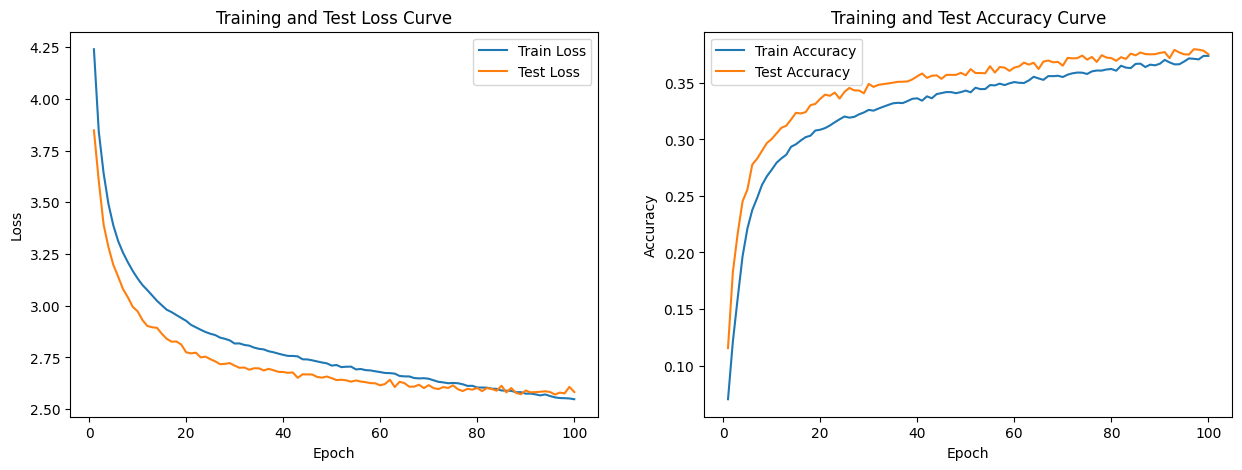

In [6]:
#Testing against the test dataset

model = CATTransformer(alpha=best_params['alpha'],
                           embed_size=best_params['embed_size'],
                           n_cont=len(cont_columns),
                           cat_feat=[],
                           num_layers=best_params['num_layers'],
                           heads=best_params['heads'],
                           forward_expansion=best_params['forward_expansion'],
                           decoder_dropout=best_params['decoder_dropout'],
                           classification_dropout=best_params['classificiation_dropout'],
                           pre_norm_on=best_params['pre_norm_on'],
                           mlp_scale_classification=best_params['mlp_scale_classification'],
                           regression_on=False,
                           targets_classes=target_classes).to(device_in_use)
loss_functions = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = best_params['learning_rate']) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
early_stopping = EarlyStopping(patience=5)
epochs = 100 

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

for t in range(epochs):
    train_loss, train_acc = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_functions, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc = test(regression_on=False,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_functions,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}\n",file=open("log_2pi.txt", 'a'))
